# Active Learning - Committee-Based Sampling

The purpose of this notebook is to demonstrate the Active Learning technique: Committee-Based Sampling.

The notebook has been developed by Assaf Landschaft and Bernard Mcshea for the "in class paper presentation" for the course "CSCI E-81 Section 2 2016" in Harvard Extension School.

## What is Active Learning

The goal of active learning is to minimize annotation costs. In other words – to minimize the costs of creating sufficient training data for a supervised learning algorithm. The standard approach to supervised learning is to acquire a large random sample of training instances to be labeled before any learning begins. When labeling costs are high, Active Learning algorithms are used to select the most informative unlabeled instances so only those will be annotated.


## Standard imports and settings

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.size'] = 16.0
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd            # process data with pandas dataframe
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import time
import os

# The data 

The **Ohsumed** test collection (available at <ftp://medir.ohsu.edu/pub/ohsumed>) is a subset of the MEDLINE database, which is a bibliographic database of important, peer-reviewed medical literature maintained by the National Library of Medicine. The initial subset I consider in the project is the collection consisting of the first 20,000 documents from the 50,216 medical abstracts of the year 1991. The classification scheme consists of the 23 Medical Subject Headings (MeSH) categories of cardiovascular diseases group: 

| Category      | Description   |        
| ------------- | ------------- |
| C01 | Bacterial Infections and Mycoses |
| C02 | Virus Diseases |
| C03 | Parasitic Diseases |
| C04 | Neoplasms |
| C05 | Musculoskeletal Diseases |
| C06 | Digestive System Diseases |
| C07 | Stomatognathic Diseases |
| C08 | Respiratory Tract Diseases |
| C09 | Otorhinolaryngologic Diseases |
| C10 | Nervous System Diseases |
| C11 | Eye Diseases |
| C12 | Urologic and Male Genital Diseases |
| C13 | Female Genital Diseases and Pregnancy Complications |
| C14 | Cardiovascular Diseases |
| C15 | Hemic and Lymphatic Diseases |
| C16 | Neonatal Diseases and Abnormalities |
| C17 | Skin and Connective Tissue Diseases |
| C18 | Nutritional and Metabolic Diseases |
| C19 | Endocrine Diseases |
| C20 | Immunologic Diseases |
| C21 | Disorders of Environmental Origin |
| C22 | Animal Diseases |
| C23 | Pathological Conditions, Signs and Symptoms |


## Downloading the data:

* [Cardiovascular diseases abstracts](http://disi.unitn.it/moschitti/corpora/ohsumed-first-20000-docs.tar.gz) (the first 20,000 abstracts of the year 1991)

** The following code assumes that the data is extracted into folder with the name 'Data' in the same folder of the IPython notebook**

## Storing the data in a sql database

The following code iterates over the extracted data and converts the ohsumed directory structure to a single sqlite databse with the data. The original dataset is already divided to Test and Training datasets. We will keep this division.

In [2]:
import sqlite3 as sqlite

def get_all_tables(c):
    """
    Helper function - Gets a list of all the tables in the database.
    """
    all_tables = []
    c.execute('SELECT name FROM SQLITE_MASTER WHERE type = "table"')
    for tbl in c:
        all_tables.append(tbl[0])
    return all_tables

def drop_tables(c, tables):
    """
    Helper function - Checks that the specified tables exist, and for those that do, drop them.
    """
    all_tables = get_all_tables(c)
    for t in tables:
        if t in all_tables:
            c.execute('DROP TABLE %s' % t)

def create_documents_table(c):
    """
    Helper function - This function uses SQL to create the Documents table
    """
    drop_tables(c, [ 'Documents' ])
    c.execute("""CREATE TABLE Documents ( 
            DOCID TEXT PRIMARY KEY,
            NOTE_TEXT TEXT, 
            CATEGORY TEXT
        )""")

def add_document(c, docid, text, category):
    """
    Helper function - Adds one document to sql Documents database
    """
    c.execute('insert or replace into Documents values ( ?, ?, ? )', (docid, text, category))

def ohsumed2sqlite(src_root_dir, dest_sqlite):
    start_time = time.time()
    print ('Converting ohsumed directory structure {0} to sqlite database'.format(src_root_dir))

    conn_out = sqlite.connect(dest_sqlite)
    c_out = conn_out.cursor()

    fout = open(dest_sqlite, 'w')
    fout.close()

    create_documents_table(c_out)
    # Process the ohsumed directory
    dict = {}
    for root, dirs, files in os.walk(src_root_dir):
        for f in files:
            category = os.path.basename(root) # directory name is the category
            with open (os.path.join(root, f), "r") as cur_file:
                data=cur_file.read()
                if f in dict:
                    category = dict[f] + ',' + category
                dict[f] = category
                add_document(c_out, f, data, category)
    conn_out.commit()
    c_out.close()
    print("--- ohsumed2sqlite %s seconds ---" % (time.time() - start_time))

In [3]:
# Convert the training data
ohsumed2sqlite('.\\Data\\ohsumed-first-20000-docs\\training', 'training.sqlite')

# Convert the test data
ohsumed2sqlite('.\\Data\\ohsumed-first-20000-docs\\test', 'test.sqlite')

Converting ohsumed directory structure .\Data\ohsumed-first-20000-docs\training to sqlite database
--- ohsumed2sqlite 1.0526394844055176 seconds ---
Converting ohsumed directory structure .\Data\ohsumed-first-20000-docs\test to sqlite database
--- ohsumed2sqlite 1.2720887660980225 seconds ---


## Data exploration and preparation 



### Read the data from the sqlite databases into Pandas dataframes

In [4]:
con = sqlite.connect('training.sqlite')

df_train = pd.read_sql_query("SELECT * from Documents", con)

con.close()

con = sqlite.connect('test.sqlite')

df_test = pd.read_sql_query("SELECT * from Documents", con)

con.close()


### Output a random sample of 20 records

In [5]:
pd.options.display.max_colwidth = 200

df_train.sample(20)

,DOCID,NOTE_TEXT,CATEGORY
3382,0008241,Management of hypercholesterolemia in a family practice setting.\n A study was undertaken to assess physician adherence and patient compliance with the National Cholesterol Education Program guide...,C18
5112,0004119,"Effect of activity on supraventricular tachyarrhythmias after coronary artery bypass surgery.\n The purpose of this study was to evaluate patient activities, professional staff activities, backres...","C14,C23"
2453,0006190,"Are ioxaglate and iopamidol equally safe and well tolerated in cardiac angiography? A randomized, double-blind clinical study.\n A randomized, double-blind, parallel-group study was performed in 5...",C14
3158,0009916,Adherent synovial cells from nonrheumatoid arthritis do not release interleukin 1 beta and prostaglandin E2 spontaneously in longterm culture.\n Adherent synovial cells from both 13 patients witho...,"C05,C17"
5802,0007571,Importance of hemodynamic response to therapy in predicting survival with ejection fraction less than or equal to 20% secondary to ischemic or nonischemic dilated cardiomyopathy.\n To identify pat...,"C14,C23"
4541,0000384,"Transient mitral regurgitation due to mitral valve prolapse accompanied by systolic anterior motion of the mitral valve.\n A grade 4/6 systolic murmur, systolic anterior motion of the mitral valve...","C06,C14,C23"
844,0005676,"Diarrhea.\n Diarrhea is one manifestation of GI disturbance.\n Symptoms may be acute if caused by such things as infections, drug reactions, alterations in diet, heavy metal poisoning, or fecal im...",C06
589,0009360,Bilateral familial carotid body paragangliomas. Report of a case with DNA flow cytometric and cytogenetic analyses.\n A case study of bilateral familial carotid body paragangliomas with DNA flow c...,C04
5622,0006795,Titration streptomycin therapy for bilateral Meniere's disease. Follow-up report.\n Initial reports of the use of parenteral streptomycin for bilateral Meniere's disease (MD) have demonstrated suc...,"C09,C23"
4718,0002262,"Tryptophan-induced eosinophilia-myalgia syndrome \n Eight patients who became ill while taking tryptophan had myalgia, fatigue, rash, fever, edema, alopecia, arthralgias, diminished joint motion, ...","C05,C10,C15,C17,C23"


### Creating binary classification dataset

** As we see, each document is assigned one class or more. ** In this exercise I would like to implement a simple binary classification workflow, so I define 2 binary classes:
* **Positive / True** - Documents that belong to class **C14 - Cardiovascular Diseases**
* **Negative / False** - Documents that do not belong to C14

The following code converts that data to a binary classification dataset:


In [6]:
import re

def ConvertCategoryColToBinVal(df, poscat):
    df['CATEGORY'] = df['CATEGORY'].apply(lambda x: bool(re.search(poscat, x, re.IGNORECASE) and True))
    
ConvertCategoryColToBinVal(df_train, 'C14')

ConvertCategoryColToBinVal(df_test, 'C14')

Let's take another look at the data:

In [7]:
df_train.sample(20)

,DOCID,NOTE_TEXT,CATEGORY
5497,0006271,"Effects of common illnesses on infants' energy intakes from breast milk and other foods during longitudinal community-based studies in Huascar (Lima), Peru.\n To assess the effects of common infec...",False
2430,0005926,Listerial myocarditis in cardiac transplantation.\n Clinical signs of heart failure developed in two cardiac transplant recipients and were interpreted initially as graft rejection.\n Morphologic ...,True
1861,0009997,Intracavernous injection of prostaglandin E1 in combination with papaverine: enhanced effectiveness in comparison with papaverine plus phentolamine and prostaglandin E1 alone.\n We compared the er...,False
142,0002275,"Ascariasis.\n Ascaris lumbricoides is the most common helminth to infect humans.\n Infection occurs when contaminated soil containing mature eggs is swallowed.\n Clinically, infection ranges from ...",False
4459,0005464,"Spinal cord thromboplastin-induced coagulopathy in a rabbit model.\n Coagulopathy results from many diverse events, including several neurogenic causes.\n Using a rabbit model, we produced coagulo...",False
3394,0008752,Can prepregnancy care of diabetic women reduce the risk of abnormal babies?\n OBJECTIVE--To see whether a prepregnancy clinic for diabetic women can achieve tight glycaemic control in early pregna...,False
621,0002088,High levels of inflammatory phospholipase A2 activity in lumbar disc herniations.\n Inflammation of neural elements is frequently mentioned clinically in association with lumbar radiculopathy.\n M...,False
6134,0009274,"Was CEPOD right?\n This retrospective study found that the long-term (greater than 6 months) postoperative survival in ASA 4E and 5E patients was 41% and 21% respectively, in 1986.\n This supports...",False
6081,0009000,"Techniques of adjustable suture strabismus surgery.\n Adjustable sutures allow eye muscle positions to be changed following strabismus surgery, when the patient is awake and able to cooperate in m...",False
1301,0003023,Childhood stroke after minor neck trauma: case report.\n Cerebral infarction after minor trauma to the neck has rarely been reported.\n A case is presented of a child with trauma to the vertebroba...,False


### How many records do we have in the test / train datasets ?

In [8]:
print ('Training data has: ', len(df_train.index), ' documents')

print ('Test data has: ', len(df_test.index), ' documents')

Training data has:  6286  documents
Test data has:  7643  documents


### Data distribution

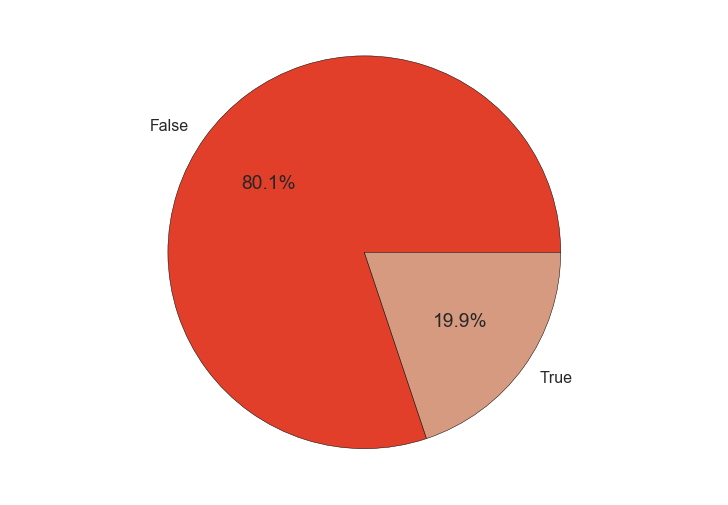

In [9]:
plt.axis('equal')
plt.pie(
    df_train.CATEGORY.value_counts().tolist(), 
    labels=['False', 'True'], 
    autopct='%1.1f%%', 
    colors=("#E13F29", "#D69A80"));

**The accuracy of a dumb classifier that classifies all the documents as False is >80%**

# Define Target classifier and test method

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score


from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
import string

stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [item for item in tokens if item.isalpha()]
    stems = stem_tokens(tokens, stemmer)
    return stems

def RenderConfusionMatrix(ytrue, ypred):
    """
    Helper function - renders confusion matrix
    """
    print(pd.crosstab(pd.Series(ytrue), pd.Series(ypred), rownames=['Actual'], colnames=['Predicted'], margins=True)) 


def TrainAndClassify_SVM(df_train, df_test):
    """
    Trains the target classifier with the df_train DataFrame dataset and then 
    classifies df_test DataFrame dataset, compares the classification results to
    the real labels and outputs the performance
    """    
    
    # Make sure there are no NaNs in the input
    df_train = df_train.dropna(subset=['NOTE_TEXT'])
    df_test = df_test.dropna(subset=['NOTE_TEXT'])
    
    
    text_clf_pipeline = Pipeline([('vect', CountVectorizer()),
                                  ('tfidf', TfidfTransformer()),
                                  ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=0.002, n_iter=10, random_state=314)),
                                 ])

    # Fit a classifier to the training data
    text_clf_pipeline.fit(df_train['NOTE_TEXT'].tolist(), df_train.CATEGORY.tolist())
    
    # Make predictions on the test data
    predictions = text_clf_pipeline.predict(df_test['NOTE_TEXT'].tolist())
    
    # Render confusion matrix
    RenderConfusionMatrix(df_test.CATEGORY.tolist(), predictions)
    
    # Output performance
    print ()
    print ('Accuracy: ', accuracy_score(df_test.CATEGORY.tolist(), predictions))
    print ()
    print (classification_report(df_test.CATEGORY.tolist(), predictions))

# Create and explore an initial training set of 200 documents

<img src="BASELINE.png">

In [11]:
def ExploreData(df):
    """
    Helper function - data exploration
    """
    print ('Training data has: ', len(df.index), ' documents')
    print (df.columns)
    print ('The shape of the data is ', (df.shape))
    plt.axis('equal')
    plt.pie(
        df.CATEGORY.value_counts().tolist(), 
        labels=['False', 'True'], 
        autopct='%1.1f%%', 
        colors=("#E13F29", "#D69A80"));

In [12]:
K = 200 # Size of the initial training set
L = 200  # The number of documents we will add to the dataset each active learning iteration


In [13]:
import random

# Create empty data frame with the columns of the test set
df_reserved_init_train_set = pd.DataFrame(columns=df_train.columns)

# Sample K random indices
random.seed(314)
initial_indices = random.sample(range(0, len(df_train.index)), K)

def MoveIndices(df_source, df_target, indices):
    """
    Helper function - moves rows in the given indices from source to target
    """
    # Add lines to target
    df_target_new = df_target.append(df_source.ix[indices])
    return df_target_new

df_reserved_init_train_set = MoveIndices(df_train, df_reserved_init_train_set, initial_indices)  



Training data has:  200  documents
Index(['DOCID', 'NOTE_TEXT', 'CATEGORY'], dtype='object')
The shape of the data is  (200, 3)


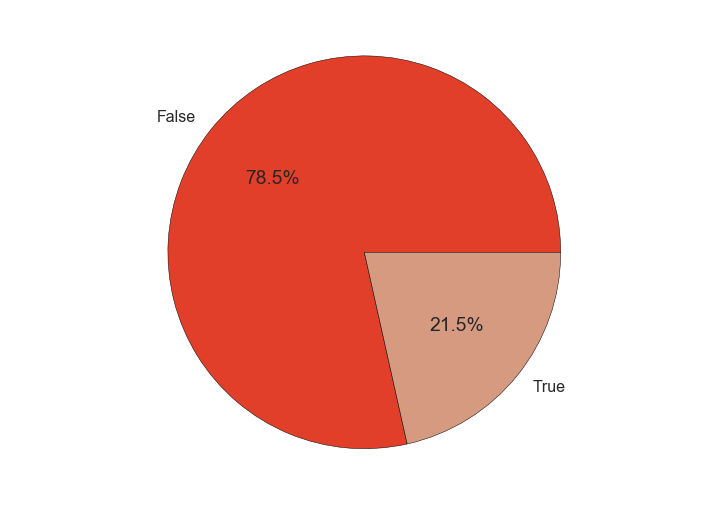

In [14]:
ExploreData(df_reserved_init_train_set)

# Train and Classify with the initial training 

In [15]:
TrainAndClassify_SVM(df_reserved_init_train_set, df_test)

Predicted  False  True   All
Actual                      
False       6255    87  6342
True         790   511  1301
All         7045   598  7643

Accuracy:  0.885254481225

             precision    recall  f1-score   support

      False       0.89      0.99      0.93      6342
       True       0.85      0.39      0.54      1301

avg / total       0.88      0.89      0.87      7643



# Baseline training set + L randomly selected  

<img src="RANDOM.png">

Training data has:  400  documents
Index(['DOCID', 'NOTE_TEXT', 'CATEGORY'], dtype='object')
The shape of the data is  (400, 3)


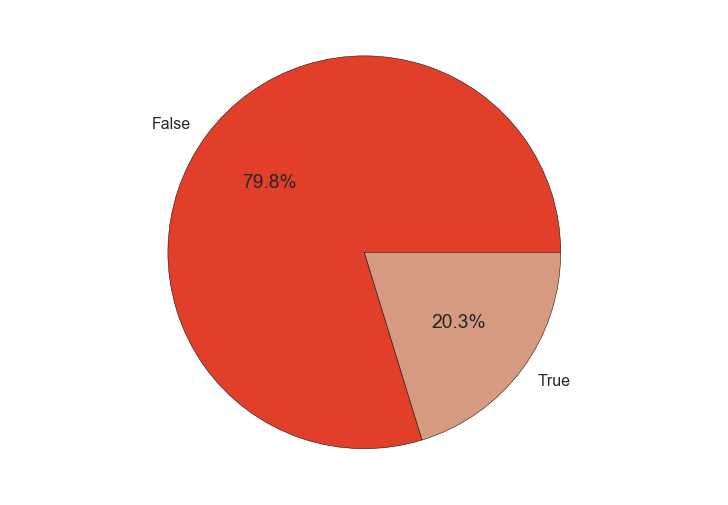

In [16]:
# Baseline training set + L randomly selected

# Create a copy of the initial training set
df_random_sample_train_set = df_reserved_init_train_set.copy(deep=True)

L_random_indices = random.sample(range(0, len(df_train.index)), L)

df_random_sample_train_set = MoveIndices(df_train, df_random_sample_train_set, L_random_indices)  

ExploreData(df_random_sample_train_set)

In [17]:
TrainAndClassify_SVM(df_random_sample_train_set, df_test)

Predicted  False  True   All
Actual                      
False       6274    68  6342
True         784   517  1301
All         7058   585  7643

Accuracy:  0.888525448122

             precision    recall  f1-score   support

      False       0.89      0.99      0.94      6342
       True       0.88      0.40      0.55      1301

avg / total       0.89      0.89      0.87      7643



# Results (so far) summary

| Training set | Accuracy | True-recall | True-f1-score |        
| ------------- | ------------- | ------------- | ------------- |
| 200 randomly selected | 0.885 | 0.39 | 0.54 |
| 200 randomly selected + 200 randomly selected | 0.888 | 0.40 | 0.55 |

# Add samples to the training set using Active Learning


<img src="ACTIVE.png">

In [22]:
# Citation:: 'http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_probas.html' 

# Active Learning - Committee-Based Sampling

import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

def ActiveLearn(df_train, df_candidates, L):
    """
    Implementation of the Active Learning algorithm Committee-Based Sampling.
    Selects the L most informative records from the labeled set df_candidates,
    , copies them to df_train and returns the extended df_train
    """  
    
    # The classifiers in our Committee-of-classifiers
    clf1 = LogisticRegression(random_state=123)
    clf2 = RandomForestClassifier(random_state=123)
    clf3 = GaussianNB()

    # Extract the relevant data 
    X_train = df_train['NOTE_TEXT'].tolist()
    Y_train = df_train.CATEGORY.tolist()
    X_candidates = df_candidates['NOTE_TEXT'].tolist()
    
    # Convert from text to word counts
    vectorizer = CountVectorizer(tokenizer=tokenize, ngram_range=(1,2))
    wcounts_train = vectorizer.fit_transform(X_train)    
    wcounts_candidates = vectorizer.transform(X_candidates)
    
    # Use each member in the Committee-of-classifiers to predict true/false probabilities
    probas = [c.fit(wcounts_train.toarray(), Y_train).predict_proba(wcounts_candidates.toarray()) 
              for c in (clf1, clf2, clf3)]
    
    K = len(df_candidates.index)
    
    # For each record - calculate one value that represents the level of disagreement
    # between all the members in the Committee-of-classifiers 
    np_doc_id_pr = np.empty((K,2), dtype=np.float64)
    num_classifer_method = 3

    for row_index in range(K):
    
        false_pr = 0.0
        true_pr = 0.0
        
        # Measure the disagreement between the classifiers for true and false predictions 
        for x in list(itertools.combinations(range(3), 2)):
            false_pr += abs(probas[x[0]][row_index][0] - probas[x[1]][row_index][0])
            true_pr += abs(probas[x[0]][row_index][1] - probas[x[1]][row_index][1])
        
        # Calculate one disagreement value - 
        # True disagreement and falst disagreement
        amortizeVotingClassifier = false_pr + true_pr

        np_doc_id_pr[row_index][0] = row_index
        np_doc_id_pr[row_index][1] = amortizeVotingClassifier
    
    tmp_np_array =  np_doc_id_pr[np_doc_id_pr[:,1].argsort()[::-1]]
    
    # Add to the training set the L samples with the highest values of disagreement
    for i in range(L):
        df_train = df_train.append(df_candidates.iloc[int(tmp_np_array[i][0])])
    return df_train



In [23]:
# Create a copy of the initial training set
df_active_learning_train_set = df_reserved_init_train_set.copy(deep=True)

L_random_indices = random.sample(range(0, len(df_train.index)), L)


In [24]:
df_final_active_learning_dataset = ActiveLearn(df_active_learning_train_set,df_train, L)

Training data has:  400  documents
Index(['DOCID', 'NOTE_TEXT', 'CATEGORY'], dtype='object')
The shape of the data is  (400, 3)


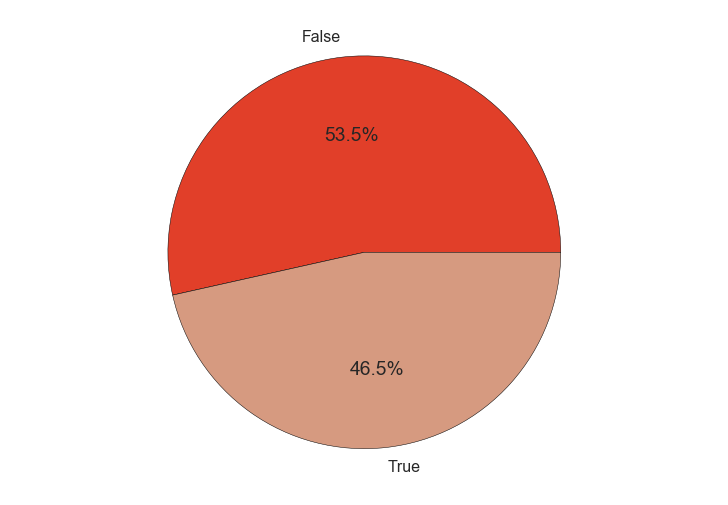

In [25]:
ExploreData(df_final_active_learning_dataset)

In [26]:
TrainAndClassify_SVM(df_final_active_learning_dataset, df_test)

Predicted  False  True   All
Actual                      
False       6055   287  6342
True         381   920  1301
All         6436  1207  7643

Accuracy:  0.91259976449

             precision    recall  f1-score   support

      False       0.94      0.95      0.95      6342
       True       0.76      0.71      0.73      1301

avg / total       0.91      0.91      0.91      7643



# Results Summary

| Training set | Accuracy | True-recall | True-f1-score |        
| ------------- | ------------- | ------------- | ------------- |
| 200 randomly selected | 0.885 | 0.39 | 0.54 |
| 200 randomly selected + 200 randomly selected | 0.888 | 0.40 | 0.55 |
| 200 randomly selected + 200 selected by Committee-Based Sampling| **0.912** | **0.71** | **0.73** |
